## Part I: Simulation of OU Process using SDE

SDE of an OU process
$$d X_t = \theta (\mu - X_t) dt + \sigma dW_t$$

- $\theta$ is the rate of mean reversion.
- $\mu$ is the long-term mean to which the process reverts.
- $\sigma$ is the volatility
- $T$ is the total (maximum) time horizon
- $dt$ is the simulation time step (the larger the better, but slower)

### Simulation of brownian motion
For a chosen time step $dt$, scaling a standard normal sample with $\sqrt{dt}$ is a good approximation to $dW_t$.

### Initial values
The initial position $X_0$ is chosen to follow $N(0.5, 1)$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_OU(X0, mu, theta, sigma, T, dt):
    """
    Simulate a trajectory of the Ornstein-Uhlenbeck process.

    Parameters:
    - X0: initial value
    - mu, theta, sigma: parameters of the OU process
    - T: total simulation time
    - dt: time step size

    Returns:
    - A tuple (times, path) where times is an array of time points and path is the simulated trajectory.
    """
    # Number of time steps
    N = int(T/dt)
    times = np.linspace(0, T, N)

    # Initialize the trajectory
    X = np.zeros(N)
    X[0] = X0

    # Simulate the path
    for t in range(1, N):
        dW = np.sqrt(dt) * np.random.randn()  # Brownian increment
        drift = theta * (mu - X[t-1]) * dt
        diffusion = sigma * dW
        X[t] = X[t-1] + drift + diffusion

    return times, X

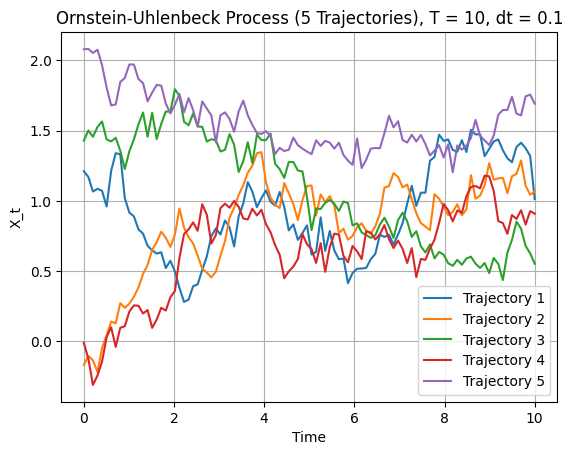

In [2]:
np.random.seed(2023)

# Parameters for the OU process
mu = 1
theta = 0.5
sigma = 0.3
T = 10
dt = 0.1
num_trajectories = 5

# Simulate & Plot
for _ in range(num_trajectories):
    X0 = np.random.normal(0.5, 1)
    times, X = simulate_OU(X0, mu, theta, sigma, T, dt)
    plt.plot(times, X)

plt.xlabel('Time')
plt.ylabel('X_t')
plt.title(f'Ornstein-Uhlenbeck Process ({num_trajectories} Trajectories), T = 10, dt = 0.1')
plt.grid(True)
plt.legend([f'Trajectory {i+1}' for i in range(num_trajectories)])
plt.show()

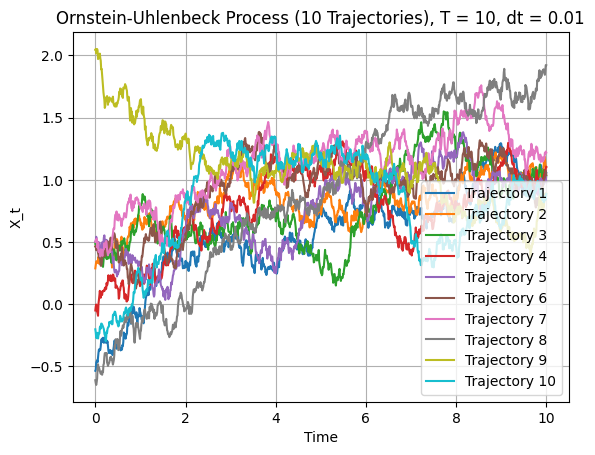

In [3]:
mu = 1
theta = 0.5
sigma = 0.3
T = 10
dt = 0.01
num_trajectories = 10

# Simulate & Plot
for _ in range(num_trajectories):
    X0 = np.random.normal(0.5, 1)
    times, X = simulate_OU(X0, mu, theta, sigma, T, dt)
    plt.plot(times, X)

plt.xlabel('Time')
plt.ylabel('X_t')
plt.title(f'Ornstein-Uhlenbeck Process ({num_trajectories} Trajectories), T = 10, dt = 0.01')
plt.grid(True)
plt.legend([f'Trajectory {i+1}' for i in range(num_trajectories)])
plt.show()

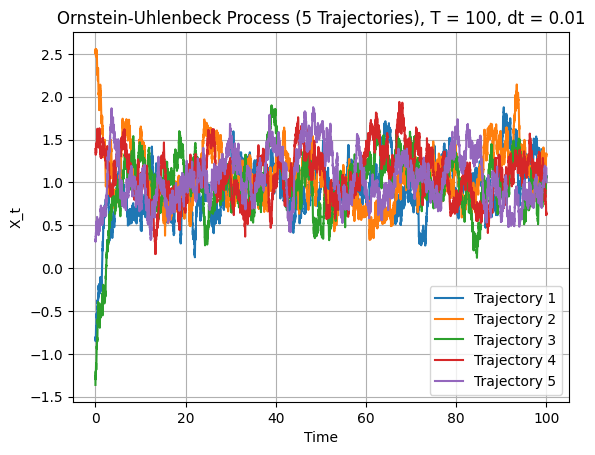

In [15]:
mu = 1
theta = 0.5
sigma = 0.3
T = 100
dt = 0.01
num_trajectories = 5

# Simulate & Plot
for _ in range(num_trajectories):
    X0 = np.random.normal(0.5, 1)
    times, X = simulate_OU(X0, mu, theta, sigma, T, dt)
    plt.plot(times, X)

plt.xlabel('Time')
plt.ylabel('X_t')
plt.title(f'Ornstein-Uhlenbeck Process ({num_trajectories} Trajectories), T = 100, dt = 0.01')
plt.grid(True)
plt.legend([f'Trajectory {i+1}' for i in range(num_trajectories)])
plt.show()

## Part II: Use Langevin Dynamics and EM Method to sample bivariate normal

A bivariate normal distribution is parametrized by a mean vector $\mu = [\mu_1, \mu_2]'$ as well as a covariance matrix
$$
\Sigma = \begin{bmatrix} \sigma_1^2 & \rho \sigma_1\sigma_2\\ \rho \sigma_1\sigma_2 & \sigma_2^2\end{bmatrix}
$$
and the resulting probability density function is
$$
p(x) = p(x_1, x_2) = \frac{1}{2\pi \sigma_1 \sigma_2 \sqrt{1 - \rho^2}} \exp{- \frac{1}{2(1 - \rho^2)} \Big[\frac{(x_1 - \mu_1)^2}{\sigma_1^2} + \frac{(x_2 - \mu_2)^2}{\sigma_2^2} - 2\rho \frac{(x_1 - \mu_1)(x_2 - \mu_2)}{\sigma_1 \sigma_2}\Big]}
$$

### Langevin Dynamics
The langevin dynamics takes the form
$$
dX_t = - \nabla U(X_t) dt + \sqrt{2} dB_t
$$
Here, U should be chosen such that $e^{-U(X)}$ is proportional to the desired probability distribution. For the bivariate Gaussian distribution, U should be the negative log of $p(x)$.

$$
U(x) = - \frac{1}{2(1 - \rho^2)} \Big[\frac{(x_1 - \mu_1)^2}{\sigma_1^2} + \frac{(x_2 - \mu_2)^2}{\sigma_2^2} - 2\rho \frac{(x_1 - \mu_1)(x_2 - \mu_2)}{\sigma_1 \sigma_2}\Big] + const
$$

### Euler-Maruyama Method
The EM Method approximates
$$
X_{t + \Delta t} = X_t - \nabla U(X_t) \Delta t + \sqrt{2 \Delta t} Z_t
$$

where $Z_t$ is a vector of two independent standard normal (so the second part also approximates the random Brownian component)

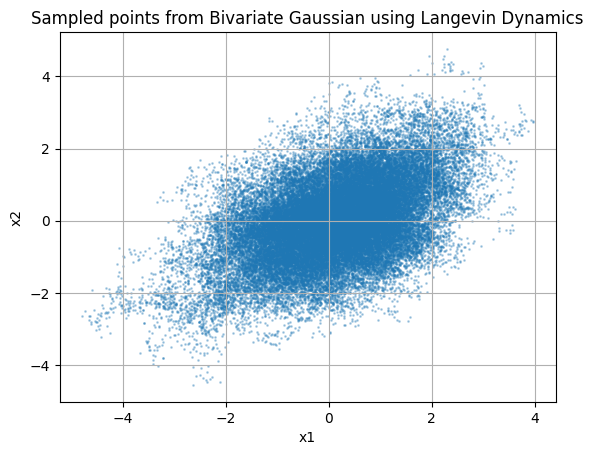

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def gradient_U(x, mu, Sigma):
    """Compute gradient of U for bivariate Gaussian."""
    sigma1_square, rho_sigma1_sigma2, _, sigma2_square = Sigma.flatten()
    rho = rho_sigma1_sigma2 / np.sqrt(sigma1_square * sigma2_square)

    grad_1 = ((x[0] - mu[0]) / sigma1_square) - (rho * (x[1] - mu[1]) / sigma2_square)
    grad_2 = ((x[1] - mu[1]) / sigma2_square) - (rho * (x[0] - mu[0]) / sigma1_square)

    return np.array([grad_1, grad_2])

def langevin_dynamics(mu, Sigma, steps, dt):
    """Simulate Langevin dynamics for bivariate Gaussian."""
    X = np.zeros((steps, 2))

    for t in range(1, steps):
        grad_U_t = gradient_U(X[t-1], mu, Sigma)
        X[t] = X[t-1] - grad_U_t * dt + np.sqrt(2*dt) * np.random.randn(2)

    return X

# Parameters for the bivariate Gaussian
mu = np.array([0, 0])
Sigma = np.array([
    [1, 0.5],
    [0.5, 1]
])

# Langevin dynamics parameters
steps = 50000
dt = 0.01

# Simulation
X_samples = langevin_dynamics(mu, Sigma, steps, dt)

# Visualization
plt.scatter(X_samples[:, 0], X_samples[:, 1], alpha=0.3, s=1)
plt.title('Sampled points from Bivariate Gaussian using Langevin Dynamics')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid(True)
plt.show()

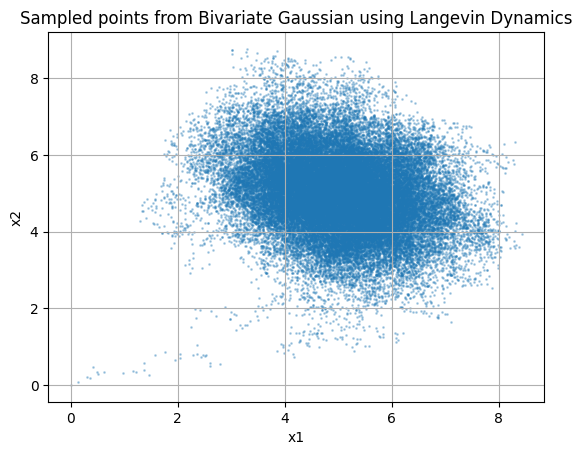

In [27]:
# Parameters for the bivariate Gaussian
mu = np.array([5, 5])
Sigma = np.array([
    [1, -0.3],
    [-0.3, 1]
])

# Langevin dynamics parameters
steps = 50000
dt = 0.01

# Simulation
X_samples = langevin_dynamics(mu, Sigma, steps, dt)

# Visualization
plt.scatter(X_samples[:, 0], X_samples[:, 1], alpha=0.3, s=1)
plt.title('Sampled points from Bivariate Gaussian using Langevin Dynamics')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid(True)
plt.show()

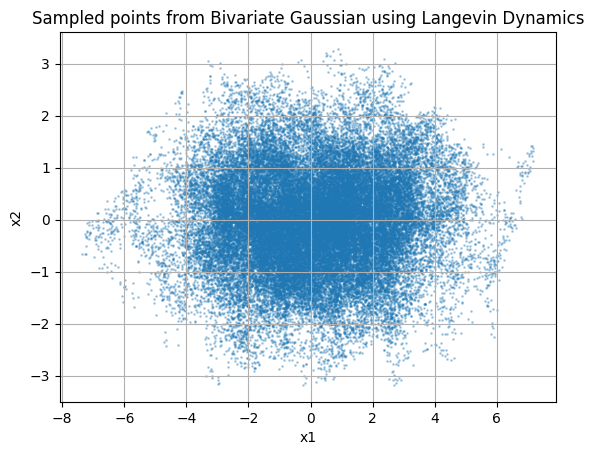

In [31]:
# Parameters for the bivariate Gaussian
mu = np.array([0, 0])
Sigma = np.array([
    [5, 0],
    [0, 1]
])

# Langevin dynamics parameters
steps = 50000
dt = 0.01

# Simulation
X_samples = langevin_dynamics(mu, Sigma, steps, dt)

# Visualization
plt.scatter(X_samples[:, 0], X_samples[:, 1], alpha=0.3, s=1)
plt.title('Sampled points from Bivariate Gaussian using Langevin Dynamics')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid(True)
plt.show()

### Part III: Altering $Q(X_t)$ for irreversible diffusion 

We consider a simple skew-symmetric rotational component to the dynamics

$$Q = \begin{bmatrix}0 & \alpha \\ -\alpha & 0\end{bmatrix}$$

where $\alpha$ is a tunable parameter controlling the strength of the rotation. This matrix induces a rotational flow in the phase space. 

In [18]:
def langevin_dynamics_Q(mu, Sigma, steps, dt, alpha):
    """Simulate Langevin dynamics for bivariate Gaussian with nonzero Q matrix."""
    X = np.zeros((steps, 2))
    Q = np.array([[0, alpha], [-alpha, 0]])

    for t in range(1, steps):
        grad_U_t = gradient_U(X[t-1], mu, Sigma)
        X[t] = X[t-1] - (grad_U_t + Q @ grad_U_t) * dt + np.sqrt(2*dt) * np.random.randn(2)
    return X

def plot_simulation(X_samples, mu, Sigma):
    # Generate the ground truth bivariate normal distribution
    x = np.linspace(-5, 5, 100)
    y = np.linspace(-5, 5, 100)
    x, y = np.meshgrid(x, y)
    z = np.exp(-0.5 * ((x - mu[0])**2/Sigma[0, 0] + (y - mu[1])**2/Sigma[1, 1] - 2*Sigma[0, 1]*(x - mu[0])*(y - mu[1])/(Sigma[0, 0]*Sigma[1, 1])))

    # Visualization
    plt.scatter(X_samples[:, 0], X_samples[:, 1], alpha=0.3, s=1)
    plt.contour(x, y, z, colors='red', alpha=0.3)  # Adding the contour lines
    plt.title('Sampled points from Bivariate Gaussian using Langevin Dynamics')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.grid(True)
    plt.show()

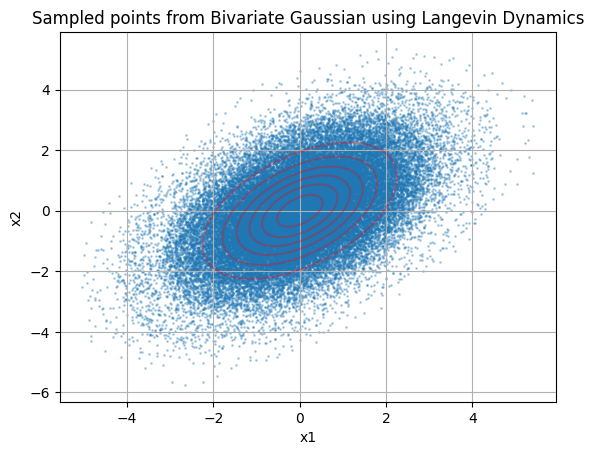

In [19]:
# Parameters for the bivariate Gaussian
mu = np.array([0, 0])
Sigma = np.array([
    [1, 0.5],
    [0.5, 1]
])

# Langevin dynamics parameters with alpha
steps = 50000
dt = 0.01
alpha = 10

X_samples = langevin_dynamics_Q(mu, Sigma, steps, dt, alpha)

plot_simulation(X_samples, mu, Sigma)

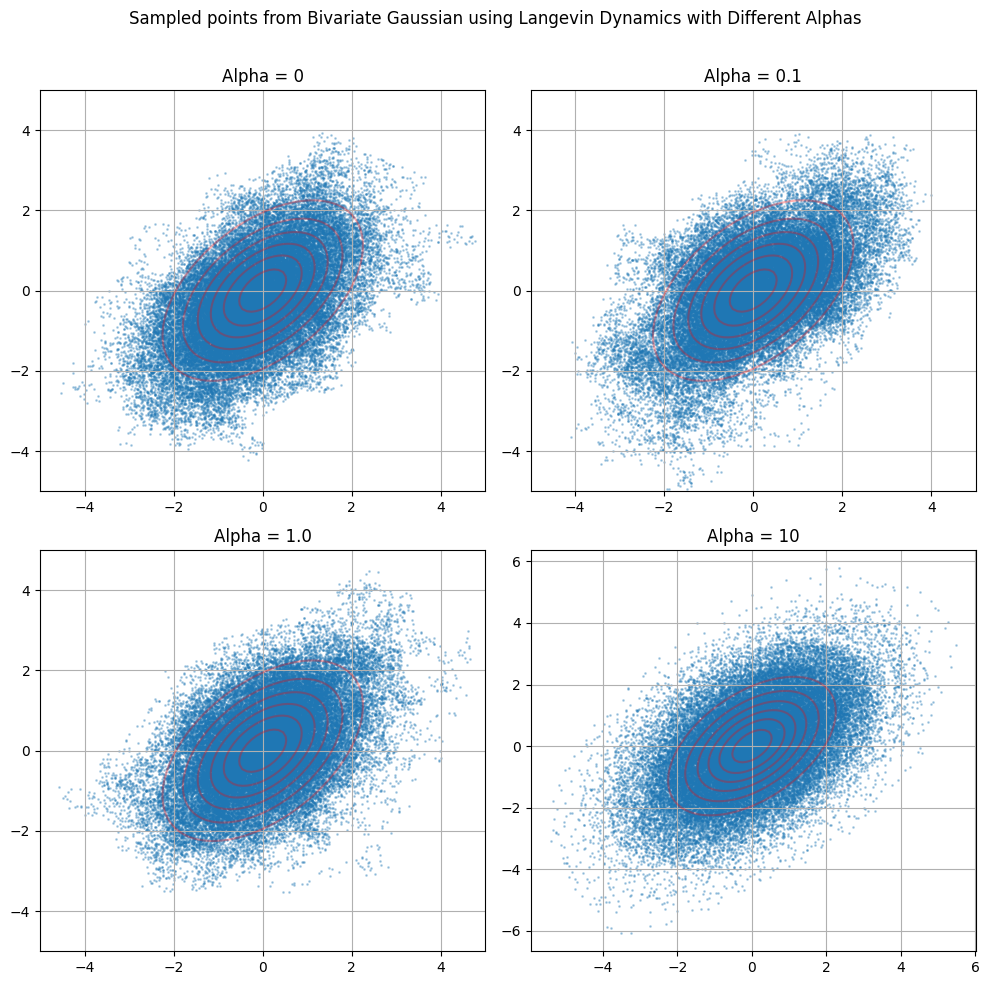

In [21]:
def plot_simulation_subplot(X_samples_list, mu, Sigma, alphas):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.ravel()

    # Generate the ground truth bivariate normal distribution
    x = np.linspace(-5, 5, 100)
    y = np.linspace(-5, 5, 100)
    x, y = np.meshgrid(x, y)
    z = np.exp(-0.5 * ((x - mu[0])**2/Sigma[0, 0] + (y - mu[1])**2/Sigma[1, 1] - 2*Sigma[0, 1]*(x - mu[0])*(y - mu[1])/(Sigma[0, 0]*Sigma[1, 1])))

    for i, (X_samples, alpha) in enumerate(zip(X_samples_list, alphas)):
        axes[i].scatter(X_samples[:, 0], X_samples[:, 1], alpha=0.3, s=1)
        axes[i].contour(x, y, z, colors='red', alpha=0.3)  # Adding the contour lines
        axes[i].set_title(f'Alpha = {alpha}')
        axes[i].grid(True)

    plt.suptitle('Sampled points from Bivariate Gaussian using Langevin Dynamics with Different Alphas')
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# List of different alphas to try
alphas = [0, 0.1, 1.0, 10]

# List to store the simulation results for different alphas
X_samples_list = []

for alpha in alphas:
    X_samples_list.append(langevin_dynamics_Q(mu, Sigma, steps, dt, alpha))

# Call the plot function with the list of results
plot_simulation_subplot(X_samples_list, mu, Sigma, alphas)


In [44]:
def plot_error_vs_iterations(mu, Sigma, steps, dt, alphas):
    true_mean = mu
    true_cov = Sigma

    interval = steps // 100
    checkpoints = np.linspace(0, steps, 100, endpoint=False).astype(int)
    
    fig, axes = plt.subplots(2, 1, figsize=(10, 10))
    
    for alpha in alphas:
        X_samples = langevin_dynamics_Q(mu, Sigma, steps, dt, alpha)
        
        mean_errors = [np.linalg.norm(np.mean(X_samples[:t+1], axis=0) - true_mean)**2 for t in checkpoints]
        
        cov_errors = [np.linalg.norm(np.cov(X_samples[:t+1], rowvar=False) - true_cov, 'fro')**2 for t in checkpoints if t > 0]
        cov_errors.insert(0, 0)  # Insert a zero at the beginning since we skip the first step

        # cov_errors_00 = [np.linalg.norm(np.cov(X_samples[:t+1], rowvar=False)[0, 0] - true_cov[0, 0])**2 for t in checkpoints if t > 0]
        # cov_errors_00.insert(0, 0)

        axes[0].plot(checkpoints[1:], mean_errors[1:], label=f'Alpha = {alpha}')
        axes[1].plot(checkpoints[1:], cov_errors[1:], label=f'Alpha = {alpha}')
    
    axes[0].set_title('Convergence of Sample Mean')
    axes[0].set_xlabel('Iterations')
    axes[0].set_ylabel('Error')
    axes[0].legend()
    
    axes[1].set_title('Convergence of Sample Covariance')
    axes[1].set_xlabel('Iterations')
    axes[1].set_ylabel('Error')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

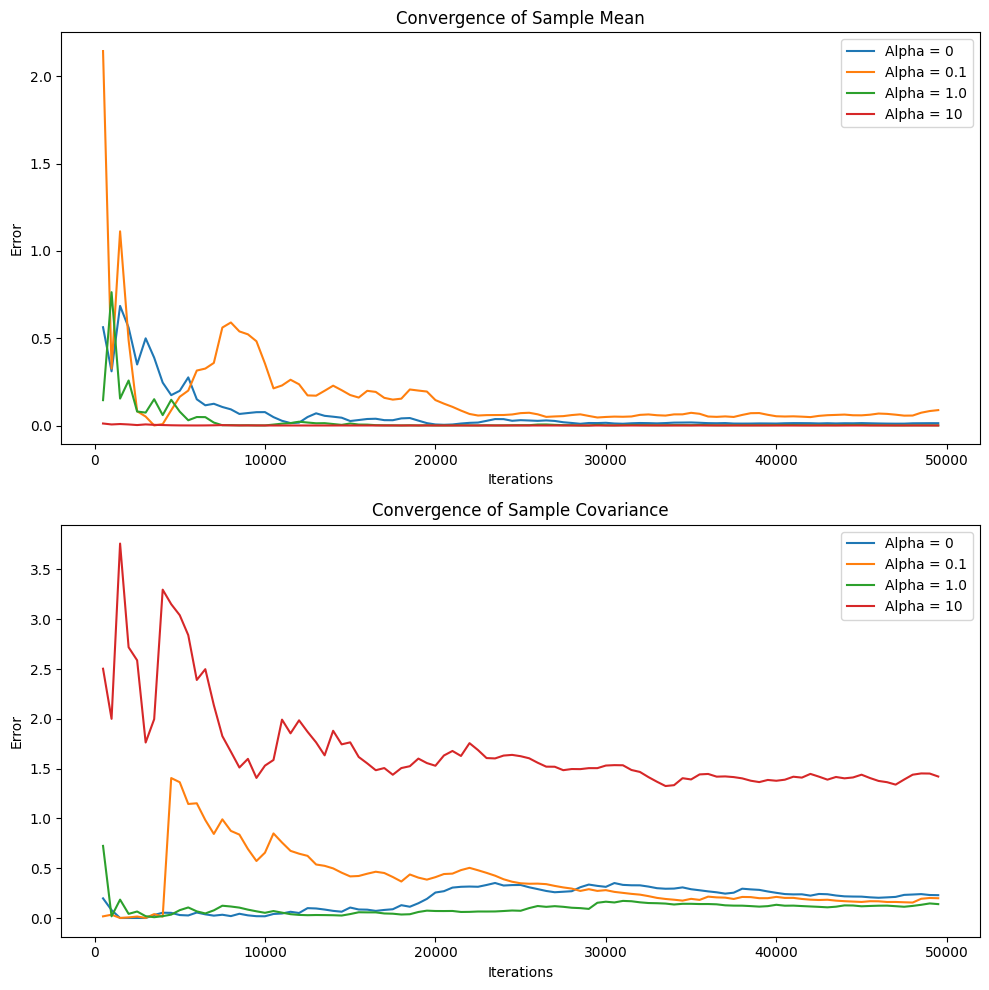

In [32]:
plot_error_vs_iterations(mu, Sigma, steps, dt, alphas)

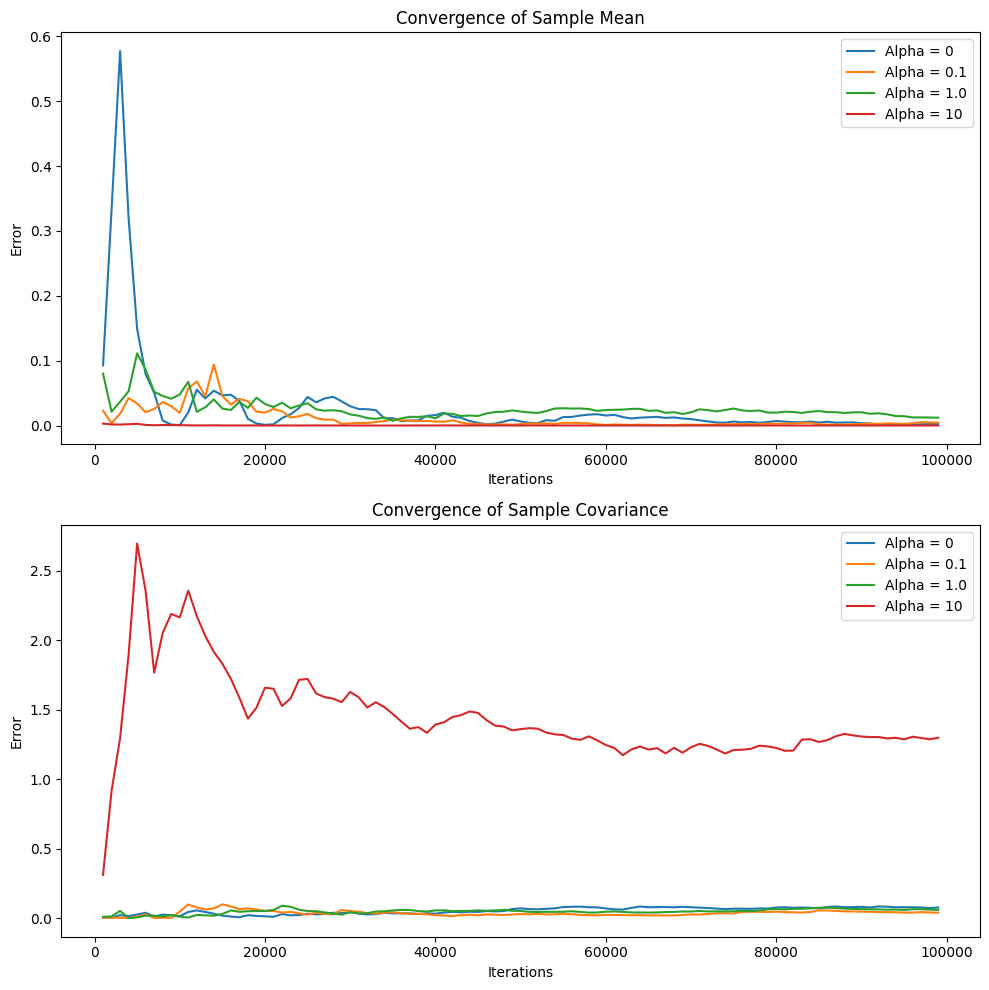

In [33]:
# Redo with a larger step size
steps_large = 100000
plot_error_vs_iterations(mu, Sigma, steps_large, dt, alphas)

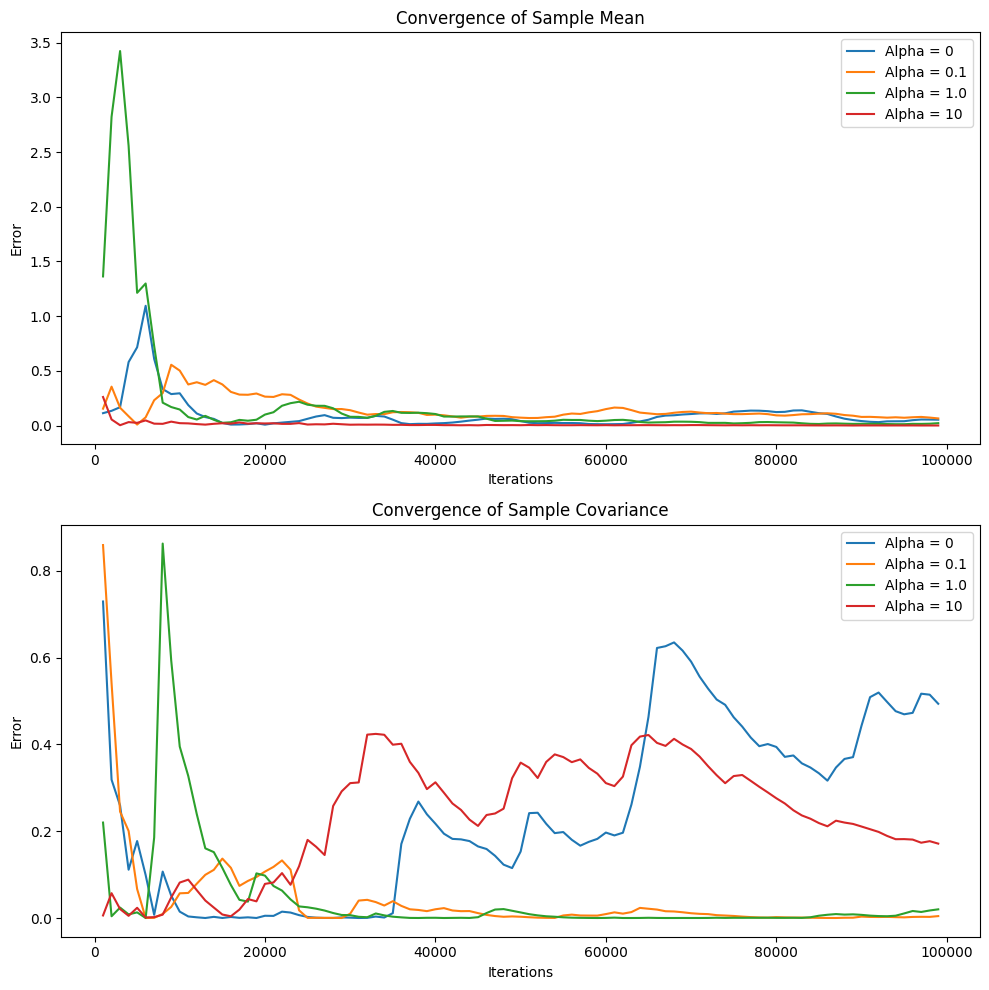

In [40]:
# investigate the potential effect of step_size in EM method
dt_01 = 0.001
plot_error_vs_iterations(mu, Sigma, steps_large, dt_01, alphas)

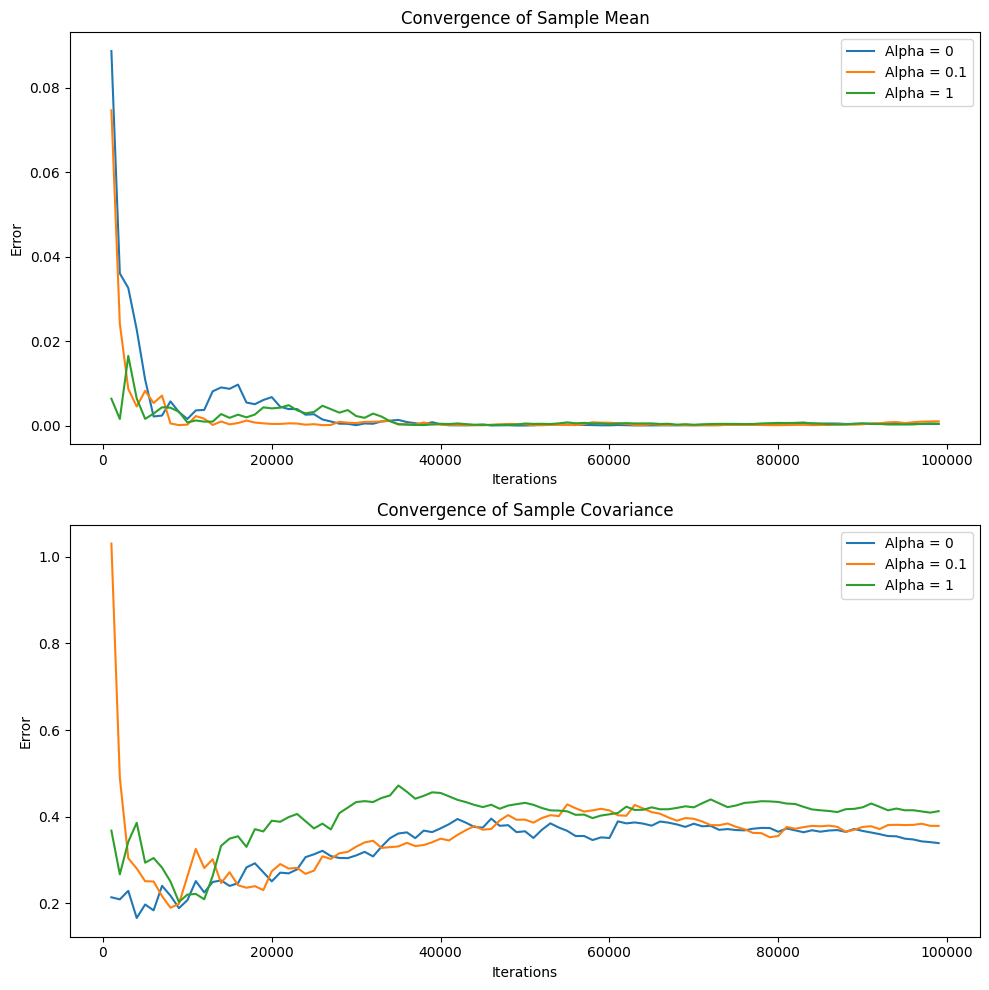

In [45]:
# larger dt will cause overflow, so discard alpha = 10 case
dt_new = 0.1
plot_error_vs_iterations(mu, Sigma, steps_large, dt_new, [0, 0.1, 1])

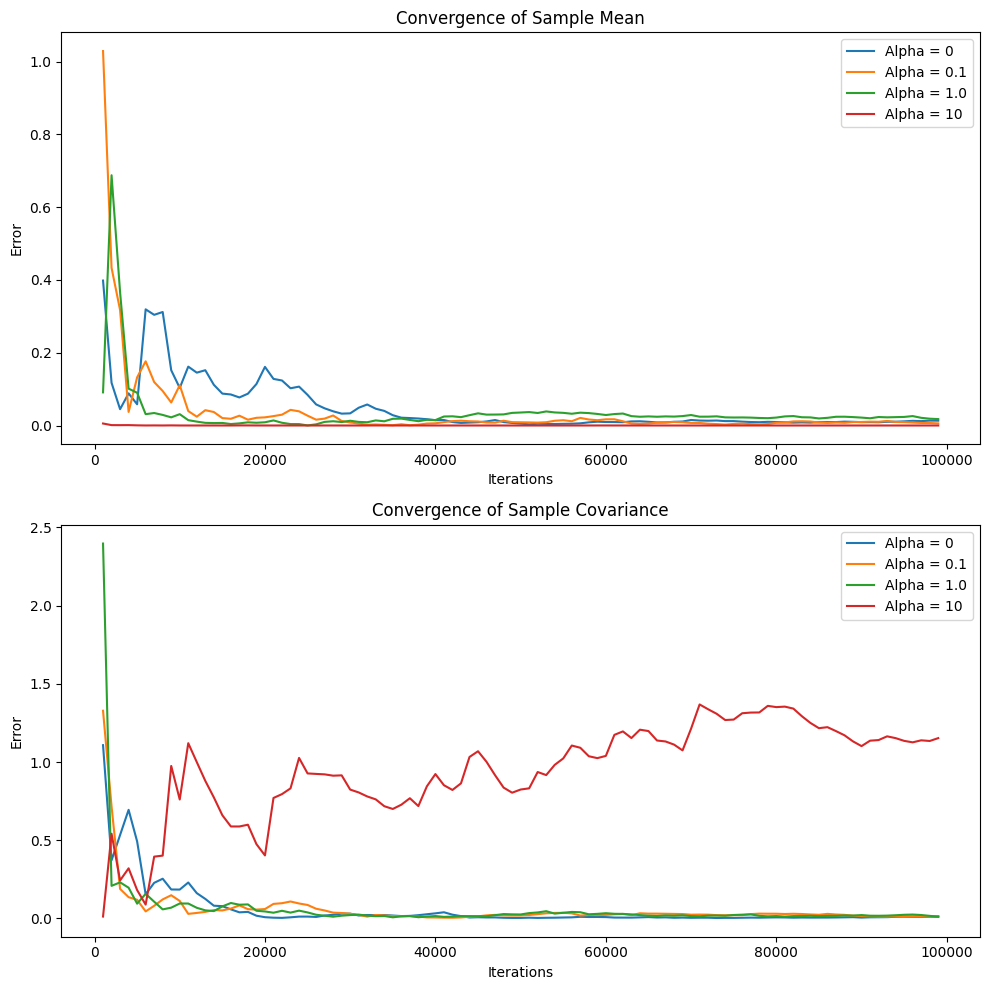

In [46]:
# Another set of mu and Sigma - easier case
# Parameters for the bivariate Gaussian
mu_new = np.array([0, 0])
Sigma_new = np.array([
    [1, 0],
    [0, 2]
])

plot_error_vs_iterations(mu_new, Sigma_new, steps_large, dt, alphas)

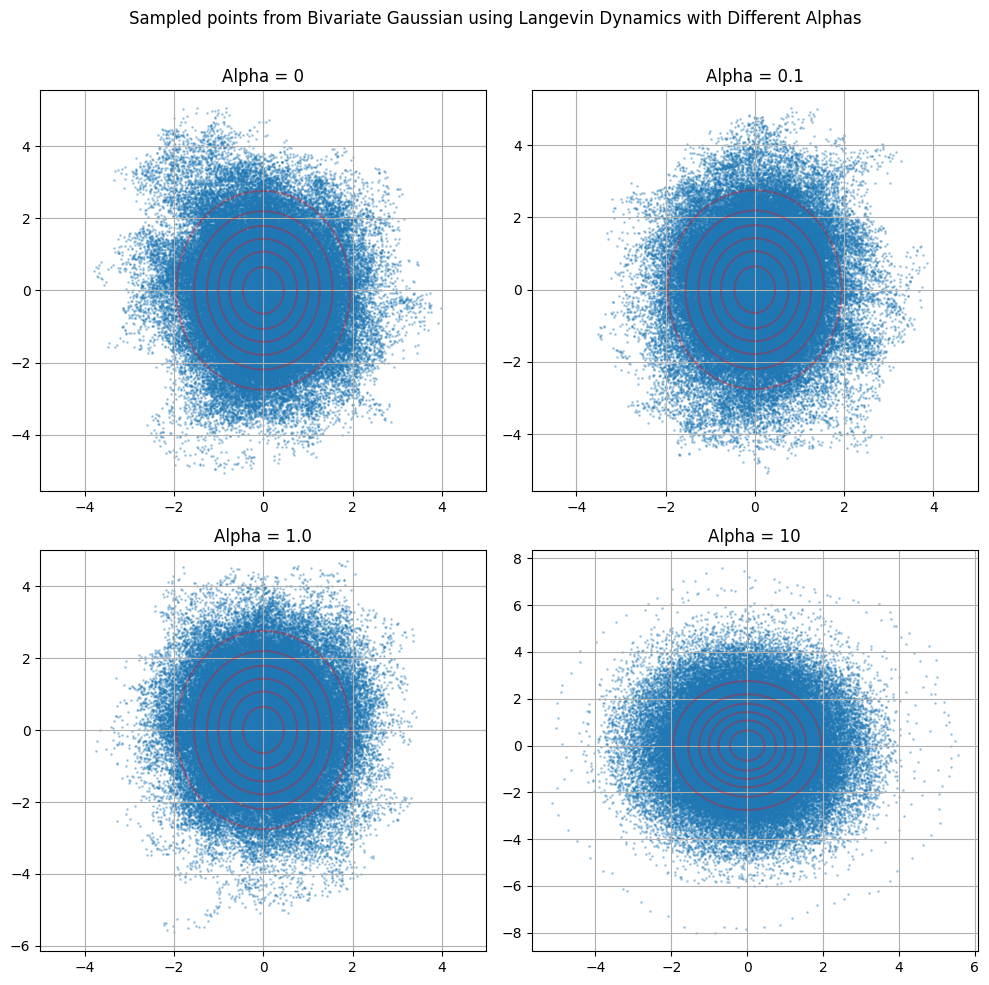

In [48]:
# List to store the simulation results for different alphas
X_samples_list = []

for alpha in alphas:
    X_samples_list.append(langevin_dynamics_Q(mu_new, Sigma_new, steps_large, dt, alpha))

# Call the plot function with the list of results
plot_simulation_subplot(X_samples_list, mu_new, Sigma_new, alphas)

### Part IV: playing around D to be inverse Fisher info matrix

Benefit from bivariate gaussian - consider its $G^{-1}$

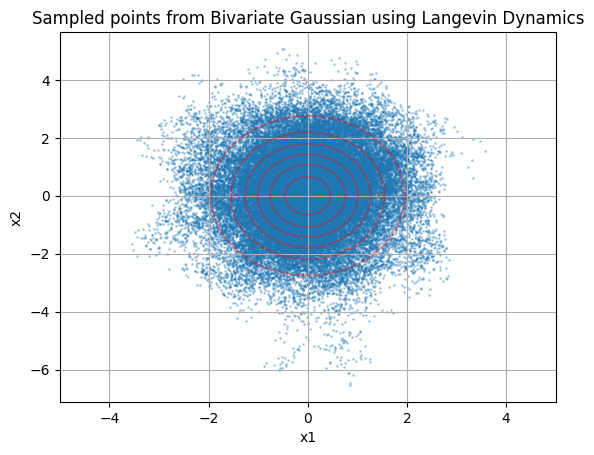

In [59]:
def langevin_dynamics_D(mu, Sigma, steps, dt):
    """Simulate Langevin dynamics for bivariate Gaussian with D as the covariance matrix."""
    X = np.zeros((steps, 2))
    inv_Sigma = np.linalg.inv(Sigma)
    
    for t in range(1, steps):
        grad_U_t = gradient_U(X[t-1], mu, Sigma)
        
        # The Γ(X_{t-1}) term is zero in this case
        
        X[t] = X[t-1] - dt * (Sigma @ grad_U_t) + np.random.multivariate_normal([0, 0], 2 * dt * Sigma)
        
    return X

# Simulation
X_samples = langevin_dynamics_D(mu_new, Sigma_new, steps, dt)

# Visualization
plot_simulation(X_samples, mu_new, Sigma_new)


In [ ]:
def plot_error_vs_iterations_extra(mu, Sigma, steps, dt, alphas):
    true_mean = mu
    true_cov = Sigma

    interval = steps // 100
    checkpoints = np.linspace(0, steps, 100, endpoint=False).astype(int)
    
    fig, axes = plt.subplots(2, 1, figsize=(10, 10))
    
    for alpha in alphas:
        X_samples = langevin_dynamics_Q(mu, Sigma, steps, dt, alpha)
        
        mean_errors = [np.linalg.norm(np.mean(X_samples[:t+1], axis=0) - true_mean)**2 for t in checkpoints]
        
        cov_errors = [np.linalg.norm(np.cov(X_samples[:t+1], rowvar=False) - true_cov, 'fro')**2 for t in checkpoints if t > 0]
        cov_errors.insert(0, 0)  # Insert a zero at the beginning since we skip the first step

        # cov_errors_00 = [np.linalg.norm(np.cov(X_samples[:t+1], rowvar=False)[0, 0] - true_cov[0, 0])**2 for t in checkpoints if t > 0]
        # cov_errors_00.insert(0, 0)

        axes[0].plot(checkpoints[1:], mean_errors[1:], label=f'Alpha = {alpha}')
        axes[1].plot(checkpoints[1:], cov_errors[1:], label=f'Alpha = {alpha}')

    X_samples_D = langevin_dynamics_D(mu, Sigma, steps, dt)
    mean_errors = [np.linalg.norm(np.mean(X_samples_D[:t+1], axis=0) - true_mean)**2 for t in checkpoints]
    cov_errors = [np.linalg.norm(np.cov(X_samples_D[:t+1], rowvar=False) - true_cov, 'fro')**2 for t in checkpoints if t > 0]
    cov_errors.insert(0, 0)  # Insert a zero at the beginning since we skip the first step
    
    axes[0].plot(checkpoints[1:], mean_errors[1:], label=f'Alpha = {alpha}')
    axes[1].plot(checkpoints[1:], cov_errors[1:], label=f'Alpha = {alpha}')
    
    axes[0].set_title('Convergence of Sample Mean')
    axes[0].set_xlabel('Iterations')
    axes[0].set_ylabel('Error')
    axes[0].legend()
    
    axes[1].set_title('Convergence of Sample Covariance')
    axes[1].set_xlabel('Iterations')
    axes[1].set_ylabel('Error')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

### 